In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima 
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [100]:
data=pd.read_csv("FinalDomesticDataset.csv",low_memory=True)

In [4]:
data.head(5)

,InvoiceDate,AvgNetFare,TotalNetFare
0,2018-01-04,4276.300000,85526.0
1,2018-01-05,4235.000000,118580.0
2,2018-01-06,4323.838710,268078.0
3,2018-01-07,3392.442308,176407.0
4,2018-01-08,4050.176030,1081397.0


In [12]:
data.shape

(701, 3)

In [13]:
data.columns

Index(['InvoiceDate', 'AvgNetFare', 'TotalNetFare'], dtype='object')

In [14]:
data.dtypes

InvoiceDate      object
AvgNetFare      float64
TotalNetFare    float64
dtype: object

In [34]:
data.describe()

,AvgNetFare,TotalNetFare
count,701.000000,7.010000e+02
mean,3930.259378,5.611272e+05
std,416.697758,6.737952e+05
min,2016.000000,0.000000e+00
25%,3634.289003,0.000000e+00
50%,3899.057554,2.712150e+05
75%,4206.110553,9.649440e+05
max,5253.862069,2.774811e+06


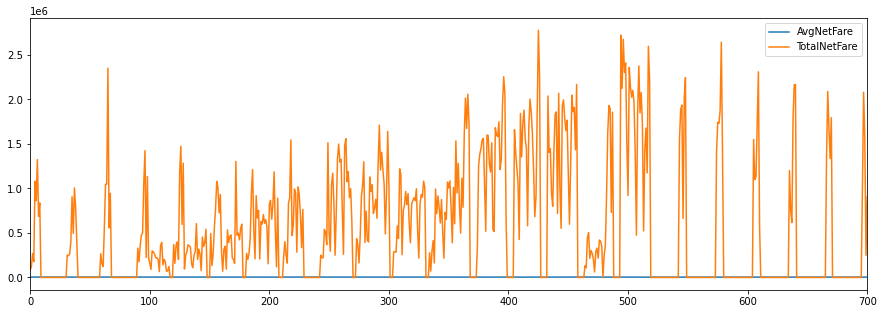

In [8]:
data.plot(figsize=(15,5))

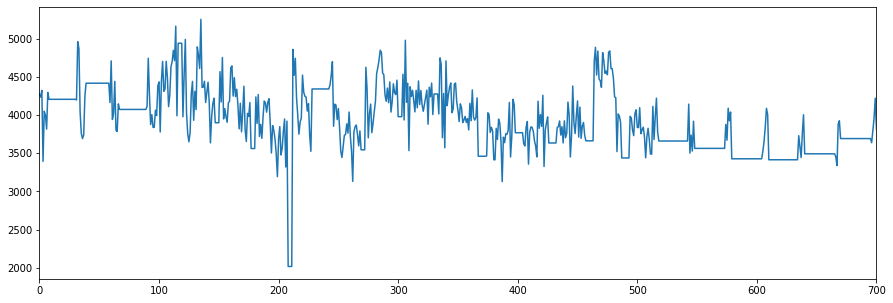

In [13]:
data.AvgNetFare.plot(figsize=(15,5))

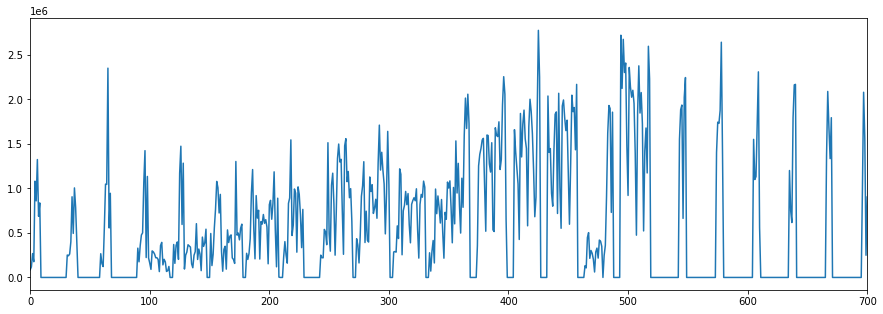

In [14]:
data.TotalNetFare.plot(figsize=(15,5))

# Quick Check for Autocorrelation

Lets findout all possible methods to find Autocorrelation.

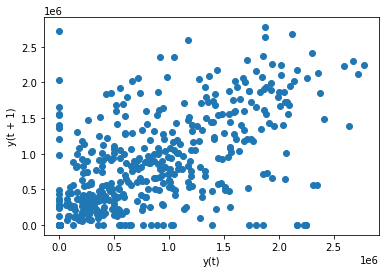

In [108]:
#Using Scatter plot
from pandas.plotting import lag_plot
series = pd.read_csv('FinalDomesticDataset.csv')
series.set_index('InvoiceDate',inplace=True)
lag_plot(series)
plt.show()

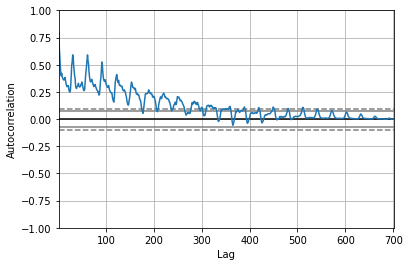

In [109]:
#autocorrelation_plot
autocorrelation_plot(series)
plt.show()

In [110]:
series.corr()

,AvgNetFare,TotalNetFare
AvgNetFare,1.000000,0.012331
TotalNetFare,0.012331,1.000000


In [111]:
#Total NetFare has low correlation, And which is also not feasable to use in the model building.
#So lets drop "TotalNetfare"
data=data.drop("TotalNetFare",axis=1)

In [112]:
data.head(10)

,InvoiceDate,AvgNetFare
0,2018-01-04,4276.300000
1,2018-01-05,4235.000000
2,2018-01-06,4323.838710
3,2018-01-07,3392.442308
4,2018-01-08,4050.176030
5,2018-01-09,3998.893023
6,2018-01-10,3815.536023
7,2018-01-11,4295.706250
8,2018-01-12,4206.110553
9,2018-01-13,4206.110553


In [113]:
data.tail(3)

,InvoiceDate,AvgNetFare
698,2019-12-03,3957.569975
699,2019-12-04,4220.576271
700,2019-12-05,3812.881857


In [16]:
type(data)

pandas.core.frame.DataFrame

In [95]:
series_value=data.values

In [18]:
type(series_value)

numpy.ndarray

In [19]:
data.size

1402

In [39]:
data.tail()

,InvoiceDate,AvgNetFare
696,2019-12-01,3637.807407
697,2019-12-02,3801.884826
698,2019-12-03,3957.569975
699,2019-12-04,4220.576271
700,2019-12-05,3812.881857


In [114]:
data.set_index('InvoiceDate',inplace=True)

# Check Stationarity using different methods.

lets plot Trend , Seasonality , Errors

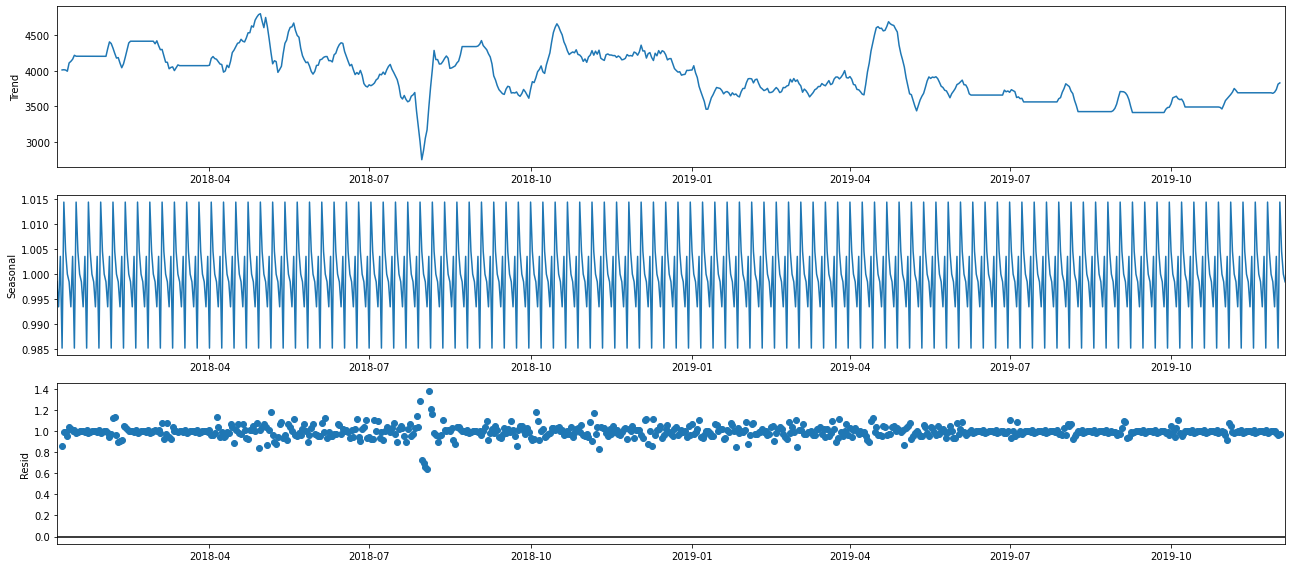

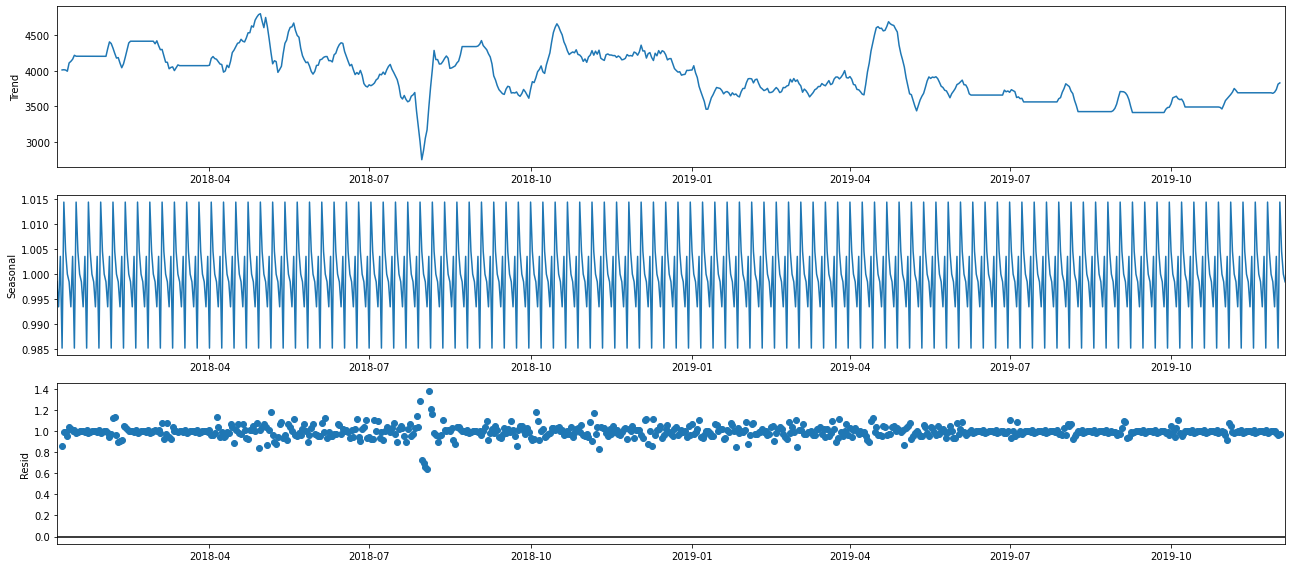

In [87]:
#Using seasonal_decompose
df_ETS = pd.read_csv('FinalDomesticDataset.csv',index_col ='InvoiceDate',parse_dates = True) 
df_ETS.head(5)
df_ETS=df_ETS.drop(['TotalNetFare'], axis = 1) 
result = seasonal_decompose(df_ETS,model ='multiplicative')

# ETS plot  
result.plot(observed=False,
    seasonal=True,
    trend=True,
    resid=True,
    weights=False) 

#ETS Decomposition
#ETS Decomposition is used to separate different components of a time series. 
#The term ETS stands for Error, Trend, and Seasonality

As we can see here there is No perfect trend like increaseing or decreaseing order, 
and also we can observe there is no seasonality. Lets confirm with ADF and KPSS.

Lets Try ADF (Augmented Dickey Fuller) Test

In [92]:
#Lets check for stationarity of Dataset using ADF:
X = data["AvgNetFare"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is 'NOT' Stationary")
    print ("Accepting H1 - Time Series is 'Stationary'")
else:
    print ("Failed to Reject Ho - Time Series is Stationary")

ADF Statistic: -4.239188
p-value: 0.000565
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject Ho - Time Series is 'NOT' Stationary
Accepting H1 - Time Series is 'Stationary'


Test for stationarity: If the test statistic is less than the critical value, 
we can reject the null hypothesis (aka the series is stationary). 
When the test statistic is greater than the critical value, 
we fail to reject the null hypothesis (which means the series is not stationary). 


In our case ADF Statistic < Critical values >> Rejecting Null{NULL: Not Stationary}.

In [97]:
#KPSS test... its Hypothesis are opposite to ADF.
def kpss_test(data, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(data, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data)

KPSS Statistic: 1.8419603984293513
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


If KPSS >>> "not stationary" and ADF = "stationary" then, use differencing to make series strict stationary

In [89]:
data['AvgNetFare'].min(), data['AvgNetFare'].max()

(2016.0, 5253.862068965517)

In [9]:
#Lets use basic Rolling mean approach {Naive_Model}
data_mean=data.rolling(window=30).mean()

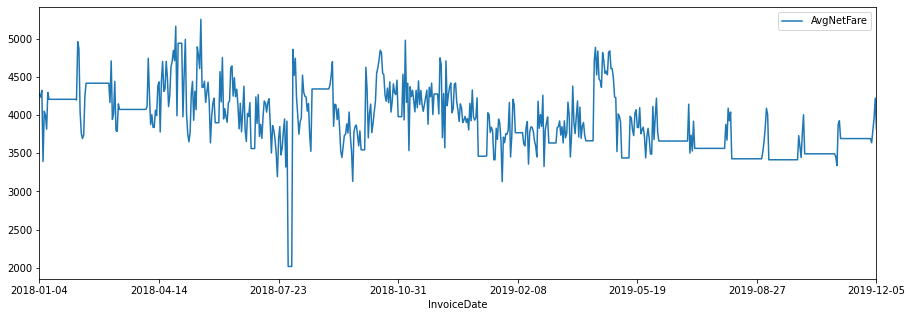

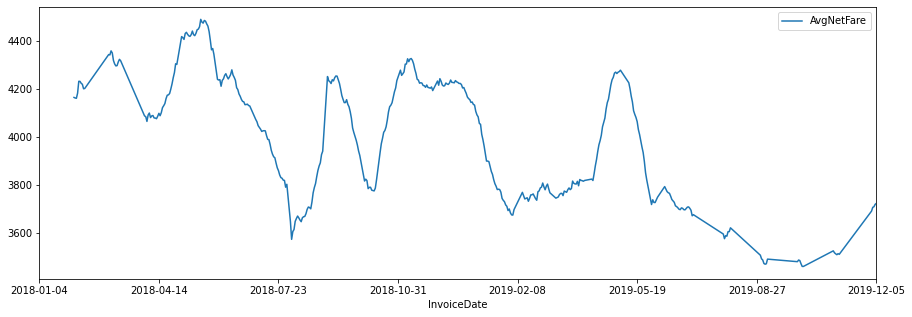

In [47]:
data.plot(figsize=(15,5))
data_mean.plot(figsize=(15,5))

Creating a Baseline model...Moving Average...>>> Recent history(t) is best reflection of Future(t+1)

In [38]:
value=pd.DataFrame(series_value)

In [39]:
data_df=pd.concat([value,value.shift(1)],axis=1)

In [12]:
data_df.head(5)

,0,1,0,1
0,2018-01-04,4276.3,NaN,NaN
1,2018-01-05,4235,2018-01-04,4276.3
2,2018-01-06,4323.84,2018-01-05,4235
3,2018-01-07,3392.44,2018-01-06,4323.84
4,2018-01-08,4050.18,2018-01-07,3392.44


In [40]:
data_df.columns = ['Actual_InvoiceDate','Actual_AvgNetFare','Forecast_InvoiceDate','Forecast_AvgNetFare']

In [14]:
data_df.head(3)

,Actual_InvoiceDate,Actual_AvgNetFare,Forecast_InvoiceDate,Forecast_AvgNetFare
0,2018-01-04,4276.3,NaN,NaN
1,2018-01-05,4235,2018-01-04,4276.3
2,2018-01-06,4323.84,2018-01-05,4235


In [24]:
data_df_test=data_df[1:]

In [16]:
data_df_error=mean_squared_error(data_df_test.Actual_AvgNetFare,data_df_test.Forecast_AvgNetFare)
data_df_error

96886.32474658724

In [17]:
np.sqrt(data_df_error)

311.26568192877806

So this Base model is like a threshold. All our advanced model predictions "RMSE" values must be less than the base model"RMSE"

In [25]:
mean_absolute_error(data_df_test.Actual_AvgNetFare,data_df_test.Forecast_AvgNetFare)

175.10774593347617

since the absolute value is less sensitive to extreme values, compared with the square function. 

# Arima

Lets use ARIMA:Non-seasonal Autoregressive Integrated Moving Averages #Arima (p,d,q)

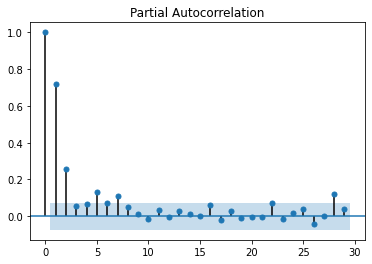

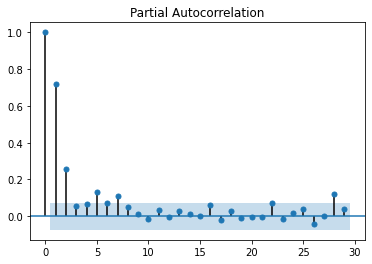

In [29]:
#To find out p for AR.
plot_pacf(data)

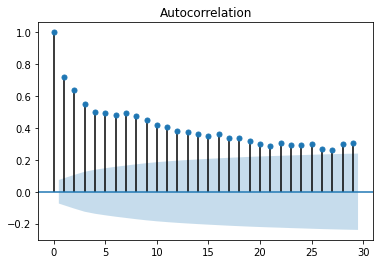

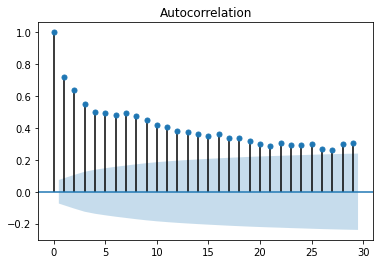

In [40]:
#Plot acf is to identify parameter (q) for "MA"
plot_acf(data)

In [41]:
len(data)-30

671

In [42]:
#Split train test
xTrain,xTest = data['AvgNetFare'][:671],data['AvgNetFare'][671:]

In [329]:
print(xTest)
len(xTest)

InvoiceDate
2019-11-06    3691.629630
2019-11-07    3691.629630
2019-11-08    3691.629630
2019-11-09    3691.629630
2019-11-10    3691.629630
2019-11-11    3691.629630
2019-11-12    3691.629630
2019-11-13    3691.629630
2019-11-14    3691.629630
2019-11-15    3691.629630
2019-11-16    3691.629630
2019-11-17    3691.629630
2019-11-18    3691.629630
2019-11-19    3691.629630
2019-11-20    3691.629630
2019-11-21    3691.629630
2019-11-22    3691.629630
2019-11-23    3691.629630
2019-11-24    3691.629630
2019-11-25    3691.629630
2019-11-26    3691.629630
2019-11-27    3691.629630
2019-11-28    3691.629630
2019-11-29    3691.629630
2019-11-30    3691.629630
2019-12-01    3637.807407
2019-12-02    3801.884826
2019-12-03    3957.569975
2019-12-04    4220.576271
2019-12-05    3812.881857
Name: AvgNetFare, dtype: float64


30

In [192]:
arima = ARIMA(xTrain,order=(4,0,1)) #P=2 d=0 q=1
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             AvgNetFare   No. Observations:                  671
Model:                     ARMA(4, 1)   Log Likelihood               -4731.812
Method:                       css-mle   S.D. of innovations            279.256
Date:                Sun, 12 Jul 2020   AIC                           9477.624
Time:                        18:00:51   BIC                           9509.185
Sample:                    01-04-2018   HQIC                          9489.848
                         - 11-05-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3933.9124    101.965     38.581      0.000    3734.064    4133.760
ar.L1.AvgNetFare     1.3494      0.083     16.235      0.000       1.187       1.512
ar.L2.AvgNetFare    -0.2345      0.072     -3.240      0.001      -0.376      -0.093
ar.L3.AvgNetFare    -0.1789      0.065     -2.770      0.006      -0.305      -0.052
ar.L4.AvgNetFare     0.0501      0.046      1.081      0.280      -0.041       0.141
ma.L1.AvgNetFare    -0.8624      0.075    -11.499      0.000      -1.009      -0.715
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0261           -0.0000j            1.0261           -0.0000
AR.2           -2.7320           -0.0000j            2.7320           -0.5000
AR.3            2.6396           -0.3966j            2.6693           -0.0237
AR.4            2.6396           +0.3966j            2.6693            0.0237
MA.1            1.1596           +0.0000j            1.1596            0.0000
-----------------------------------------------------------------------------
"""

In [193]:
pred = arima.forecast(steps=len(xTest))


print(mean_squared_error(xTest,pred[0]))
print(np.sqrt(mean_squared_error(xTest,pred[0]))) #Selecting 0th Sample for forecasting {i.e 1st sample}

9967.243361959678
99.836082465007


In [219]:
mean_absolute_error(xTest,pred[0])

62.57582786544182

In [ ]:
#prediction

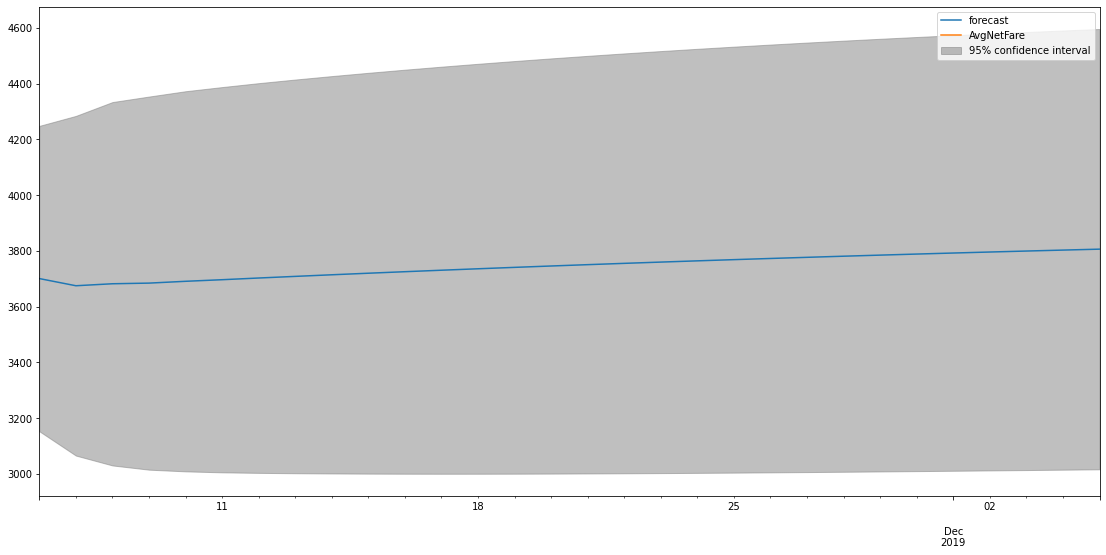

In [74]:
ax=arima.plot_predict(start='2019-11-06' , end='2019-12-05')
ax.set_figheight(9)
ax.set_figwidth(19)

In [118]:
#Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [148]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic,l.append(results.aic)))
            
            
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13583.201840016267
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:12876.589946723021
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10407.741822893193
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:9967.997831562087
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10420.382730486761
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10154.87003537424
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10109.515866533035
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:9956.624115990526
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13066.39217549332
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:11851.502794362852
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10243.797611663278
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:9758.250562696992
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10269.299027663323
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9921.693073988072
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:9940.231065495716
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:9753.38359787043
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:10012.084849006498
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:9837.161429291667
AR

In [151]:
#Lets check which is the lowest AIC we got
np.min(l)

9552.817655896768

In [ ]:
#ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:9552.817655896768

# Fitting Sarima

In [187]:
sar = SARIMAX(xTrain,order=(1,1,1),seasonal_order=(0, 1, 1, 12),trend='n',)
sar= sar.fit()



print(sar.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3979      0.037     10.690      0.000       0.325       0.471
ma.L1         -0.8641      0.021    -41.220      0.000      -0.905      -0.823
ma.S.L12      -0.9969      0.301     -3.309      0.001      -1.587      -0.406
sigma2      8.042e+04   2.35e+04      3.420      0.001    3.43e+04    1.27e+05


In [188]:
pred = sar.forecast(steps=len(xTest))

print(mean_squared_error(xTest,pred))
print(np.sqrt(mean_squared_error(xTest,pred)))

34061.72896105954
184.55819938723812


In [191]:
mean_absolute_error(xTest,pred)

142.29199181009093

In [ ]:
#Lets try changing the parameter of SARIMA with auto-arima

In [253]:
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(xTrain, start_p = 1, start_q = 1, 
                        max_p = 3, max_q = 3, m = 12, 
                        start_P = 0, seasonal = True, 
                        d = None, D = 1, trace = True, 
                        error_action ='ignore', # we don't want to know if an order does not work 
                        suppress_warnings = True, # we don't want convergence warnings 
                        stepwise = True)       # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=9384.256, BIC=9406.709, Time=10.948 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=9995.111, BIC=10004.093, Time=0.082 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=9613.435, BIC=9631.398, Time=3.450 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=9537.789, BIC=9555.752, Time=4.026 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=9993.395, BIC=9997.886, Time=0.056 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=9767.134, BIC=9785.097, Time=0.406 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=9388.575, BIC=9415.519, Time=10.702 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit

In [ ]:
#Fit ARIMA(2,0,1)x(0,1,1,12) [intercept=True]; AIC=9374.746, BIC=9401.691, Time=18.197 seconds

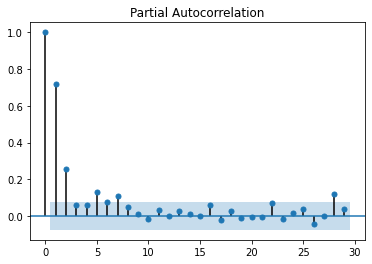

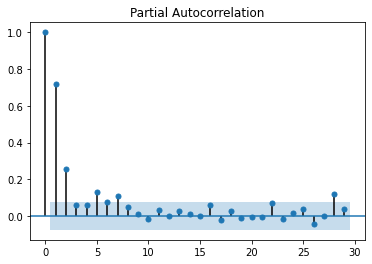

In [242]:
plot_pacf(xTrain)

In [330]:
#again fitting sarima

sar1 = SARIMAX(xTrain,order=(4,0,1),seasonal_order=(0, 1, 1, 12),trend='n',)
sar1= sar1.fit()



print(sar1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4889      0.033     45.373      0.000       1.425       1.553
ar.L2         -0.2897      0.047     -6.182      0.000      -0.382      -0.198
ar.L3         -0.1584      0.034     -4.667      0.000      -0.225      -0.092
ar.L4         -0.0409      0.021     -1.975      0.048      -0.081      -0.000
ma.L1         -0.9964      0.019    -51.367      0.000      -1.034      -0.958
ma.S.L12      -0.9724      0.044    -22.273      0.000      -1.058      -0.887
sigma2      8.682e+04   3573.058     24.297      0.000    7.98e+04    9.38e+04


In [387]:
pred1 = sar1.forecast(steps=len(xTest))

print(mean_squared_error(xTest,pred1))
print(np.sqrt(mean_squared_error(xTest,pred1)))

17079.326899266944
130.68789882489864


In [332]:
mean_absolute_error(xTest,pred1)  #So one thing we can conclude Auto arima works better compared to grid search for our dataset

71.42920066737295

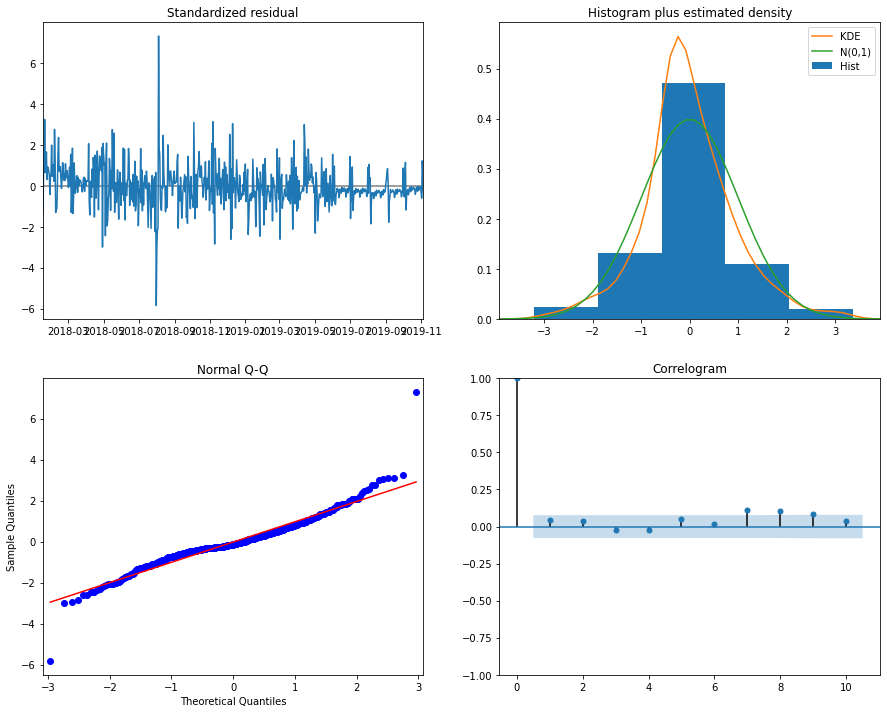

In [333]:
sar1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [431]:
Error=pred1-xTest

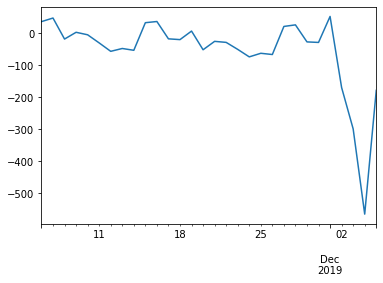

In [437]:
Error.plot()